### MobileNet Modeling

#### 학습 및 테스트 데이터 생성(oxford-pet)

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import random_split

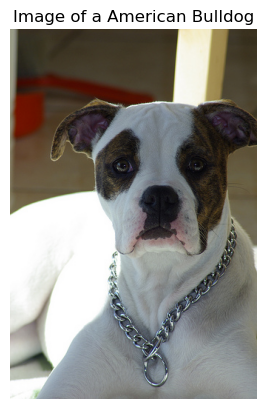

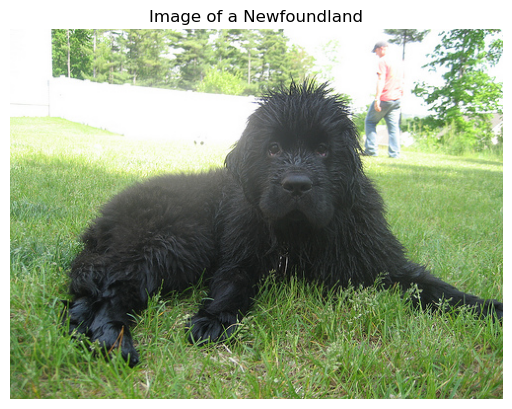

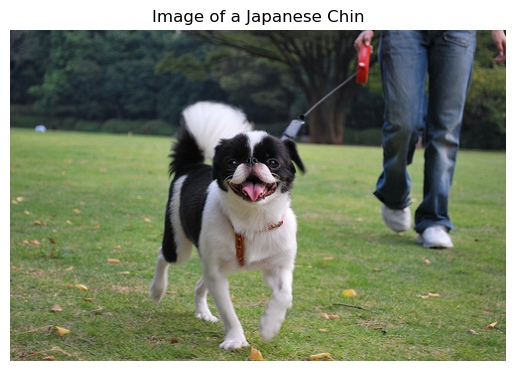

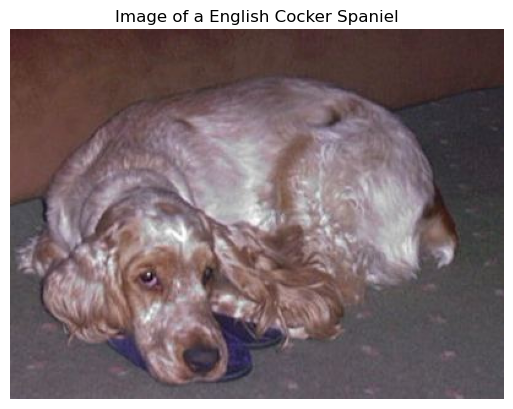

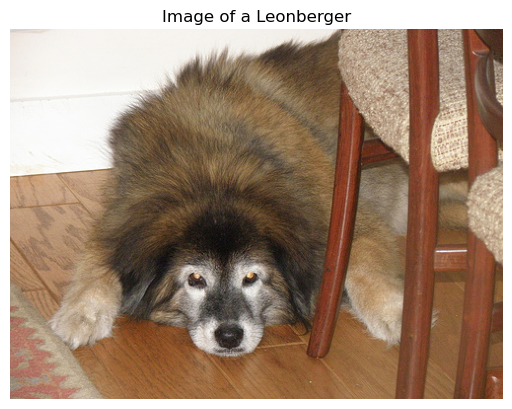

In [2]:
# data 불러오기
pet_data = torchvision.datasets.OxfordIIITPet(root="./data",split="trainval",download=True)

for i in range(5):
    image, label = pet_data[random.choice(range(len(pet_data)))]

    fig = plt.figure()
    plt.imshow(image)
    plt.title(f"Image of a {pet_data.classes[label]}")
    plt.axis("off")

In [3]:
# 데이터 transform 형태 정의
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    # transforms.RandAugment(),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# train & test 데이터 생성
train_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=False)
test_dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="test",transform=test_transform, download=False)

# train data 라벨(=class) 및 배치 크기 정의
classes = train_dataset.classes
num_classes = len(classes)
BATCH_SIZE = 64

# 학습에 대한 validation 데이터 정의
split_len = int(0.9*len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [split_len, len(train_dataset)-split_len], generator=torch.Generator().manual_seed(7))

# train, val, test 데이터 갯수 확인
print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(val_dataset))
print('Numuber of class in train dataset: ', num_classes)
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  3312
Length of validation dataset:  368
Numuber of class in train dataset:  37
Length of test dataset:  3669


In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, persistent_workers=True, num_workers=1, batch_size=BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, persistent_workers=True, num_workers=1, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, persistent_workers=True, num_workers=1, batch_size=BATCH_SIZE)

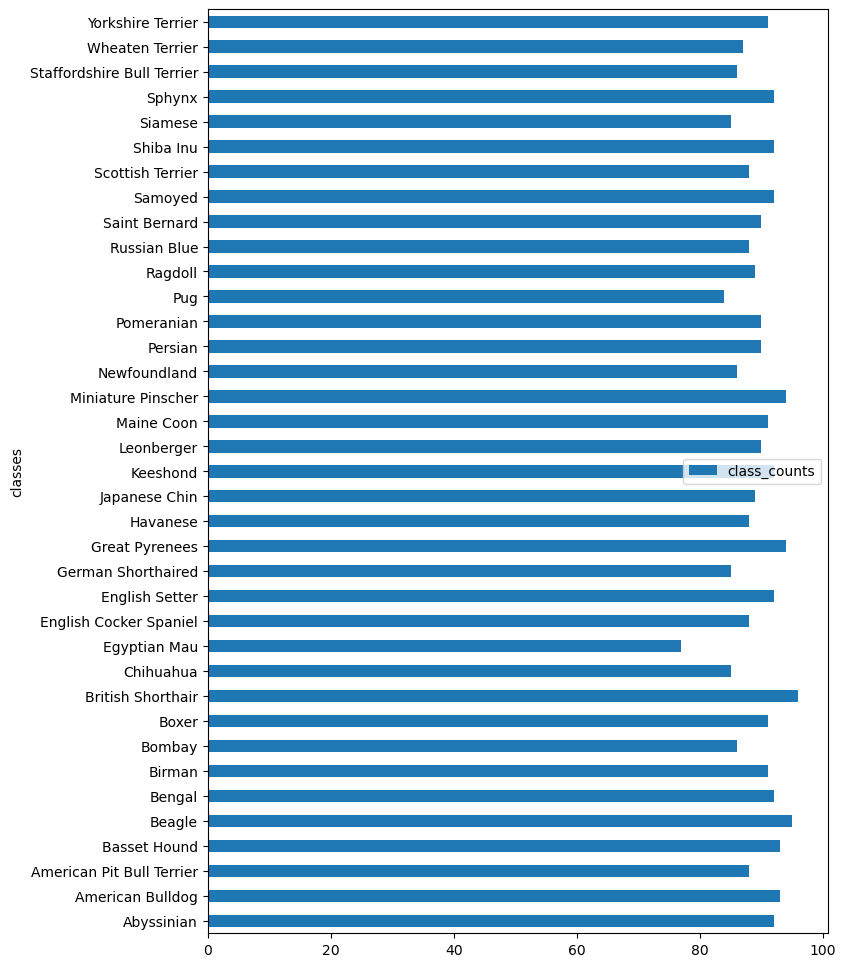

In [5]:
class_counts = np.array([0]*num_classes)

for batch in train_dataloader:
    _, labels = batch

    for label in labels:
        class_counts[label] += 1

df_classes = pd.DataFrame({"classes" : classes, "class_counts" : class_counts})

df_classes.plot(kind="barh", x="classes", y="class_counts",figsize=(8,12))
plt.show()

#### 모델 생성

##### 1. 모델 구축

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary

import torchvision
from torchvision import models
from pytorch_lightning import LightningModule, Trainer, seed_everything
from torchmetrics import MetricCollection, Accuracy, F1Score
from torch.optim.lr_scheduler import StepLR

In [7]:
model = models.mobilenet_v3_small(pretrained=True)
print(model)

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\Hyosk5/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 54.8MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [11]:
model.classifier[3]

Linear(in_features=1024, out_features=1000, bias=True)

In [12]:
seed_everything(2023, workers=True)

# Define pre_VGGNet Class
class MobileNet(LightningModule):
    def __init__(self, model, num_classes=10, learning_rate=0.001, init_weights=True):
        super().__init__()
        self.save_hyperparameters()

        # Setup VGGNet model
        self.create_model(model)

        # Setup the loss
        self.loss = nn.CrossEntropyLoss()

        # Setup the metrics.
        self.train_metrics = MetricCollection({"train_acc" : Accuracy(task="multiclass", num_classes=num_classes, average="micro"),
                                               "train_f1" : F1Score(task="multiclass", num_classes=num_classes, average="macro")})
        self.val_metrics = MetricCollection({"val_acc" : Accuracy(task="multiclass", num_classes=num_classes, average="micro"),
                                               "val_f1" : F1Score(task="multiclass", num_classes=num_classes, average="macro")})
        self.test_metrics = MetricCollection({"test_acc" : Accuracy(task="multiclass", num_classes=num_classes, average="micro"),
                                               "test_f1" : F1Score(task="multiclass", num_classes=num_classes, average="macro")})
    
    def create_model(self, model):
        if model == 'large':
            self.model = models.mobilenet_v3_large(pretrained=True)
        else:
            self.model = models.mobilenet_v3_small(pretrained=True)
        # 데이터의 class 수에 맞게 classifier 마지막 부분 수정
        last_in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(last_in_features, num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch

        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, labels)

        self.train_metrics(preds, labels)

        self.log("train_acc", self.train_metrics["train_acc"], prog_bar=True)
        self.log("train_f1", self.train_metrics["train_f1"], prog_bar=True)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def evaluate(self, batch, stage=None):
        images, labels = batch

        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        if stage == "val":
            self.val_metrics(preds,labels)

            self.log("val_acc", self.val_metrics["val_acc"], prog_bar=True)
            self.log("val_f1", self.val_metrics["val_f1"], prog_bar=True)
            self.log("val_loss", loss, prog_bar=True)
        elif stage == "test":
            self.test_metrics(preds,labels)

            self.log("test_acc", self.test_metrics["test_acc"], prog_bar=True)
            self.log("test_f1", self.test_metrics["test_f1"], prog_bar=True)
            self.log("test_loss", loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.classifier.parameters(), lr=self.hparams.learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [scheduler]


Seed set to 2023


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
pre_model = MobileNet(model='small', num_classes=num_classes, learning_rate=0.001).to(device)
print(pre_model)

MobileNet(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNo

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
summary(pre_model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [18]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [19]:
callbacks = [LearningRateMonitor(logging_interval='step')]

trainer = Trainer(
            accelerator='gpu',
            max_epochs=20,
            callbacks=callbacks,
          )

trainer.fit(pre_model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MobileNetV3      | 1.6 M 
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 52/52 [00:14<00:00,  3.67it/s, v_num=13, train_acc=1.000, train_f1=1.000, train_loss=0.0383, val_acc=0.832, val_f1=0.819, val_loss=0.677]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 52/52 [00:14<00:00,  3.66it/s, v_num=13, train_acc=1.000, train_f1=1.000, train_loss=0.0383, val_acc=0.832, val_f1=0.819, val_loss=0.677]


In [8]:
%load_ext tensorboard
%tensorboard --logdir=./lightning_logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 27816), started 2 days, 13:42:24 ago. (Use '!kill 27816' to kill it.)

In [7]:
%tensorboard --logdir=./lightning_logs --bind_all

Reusing TensorBoard on port 6006 (pid 27816), started 2 days, 13:33:48 ago. (Use '!kill 27816' to kill it.)

In [20]:
pre_best_model_path = trainer.checkpoint_callback.best_model_path
pre_best_model = MobileNet.load_from_checkpoint(pre_best_model_path)

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
trainer.test(pre_best_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.83152174949646
         test_f1            0.8193461894989014
        test_loss           0.6766294240951538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.83152174949646,
  'test_f1': 0.8193461894989014,
  'test_loss': 0.6766294240951538}]

In [22]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes, normalize='true')
prev_device = pre_best_model.device.type
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

confmat.to(device)
pre_best_model.to(device)
with torch.no_grad():
    pre_best_model.eval()

    for batch in test_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        logits = pre_best_model(images)
        preds = torch.argmax(logits, dim=1)

        confmat.update(preds, labels)

pre_best_model.to(prev_device)
1

1

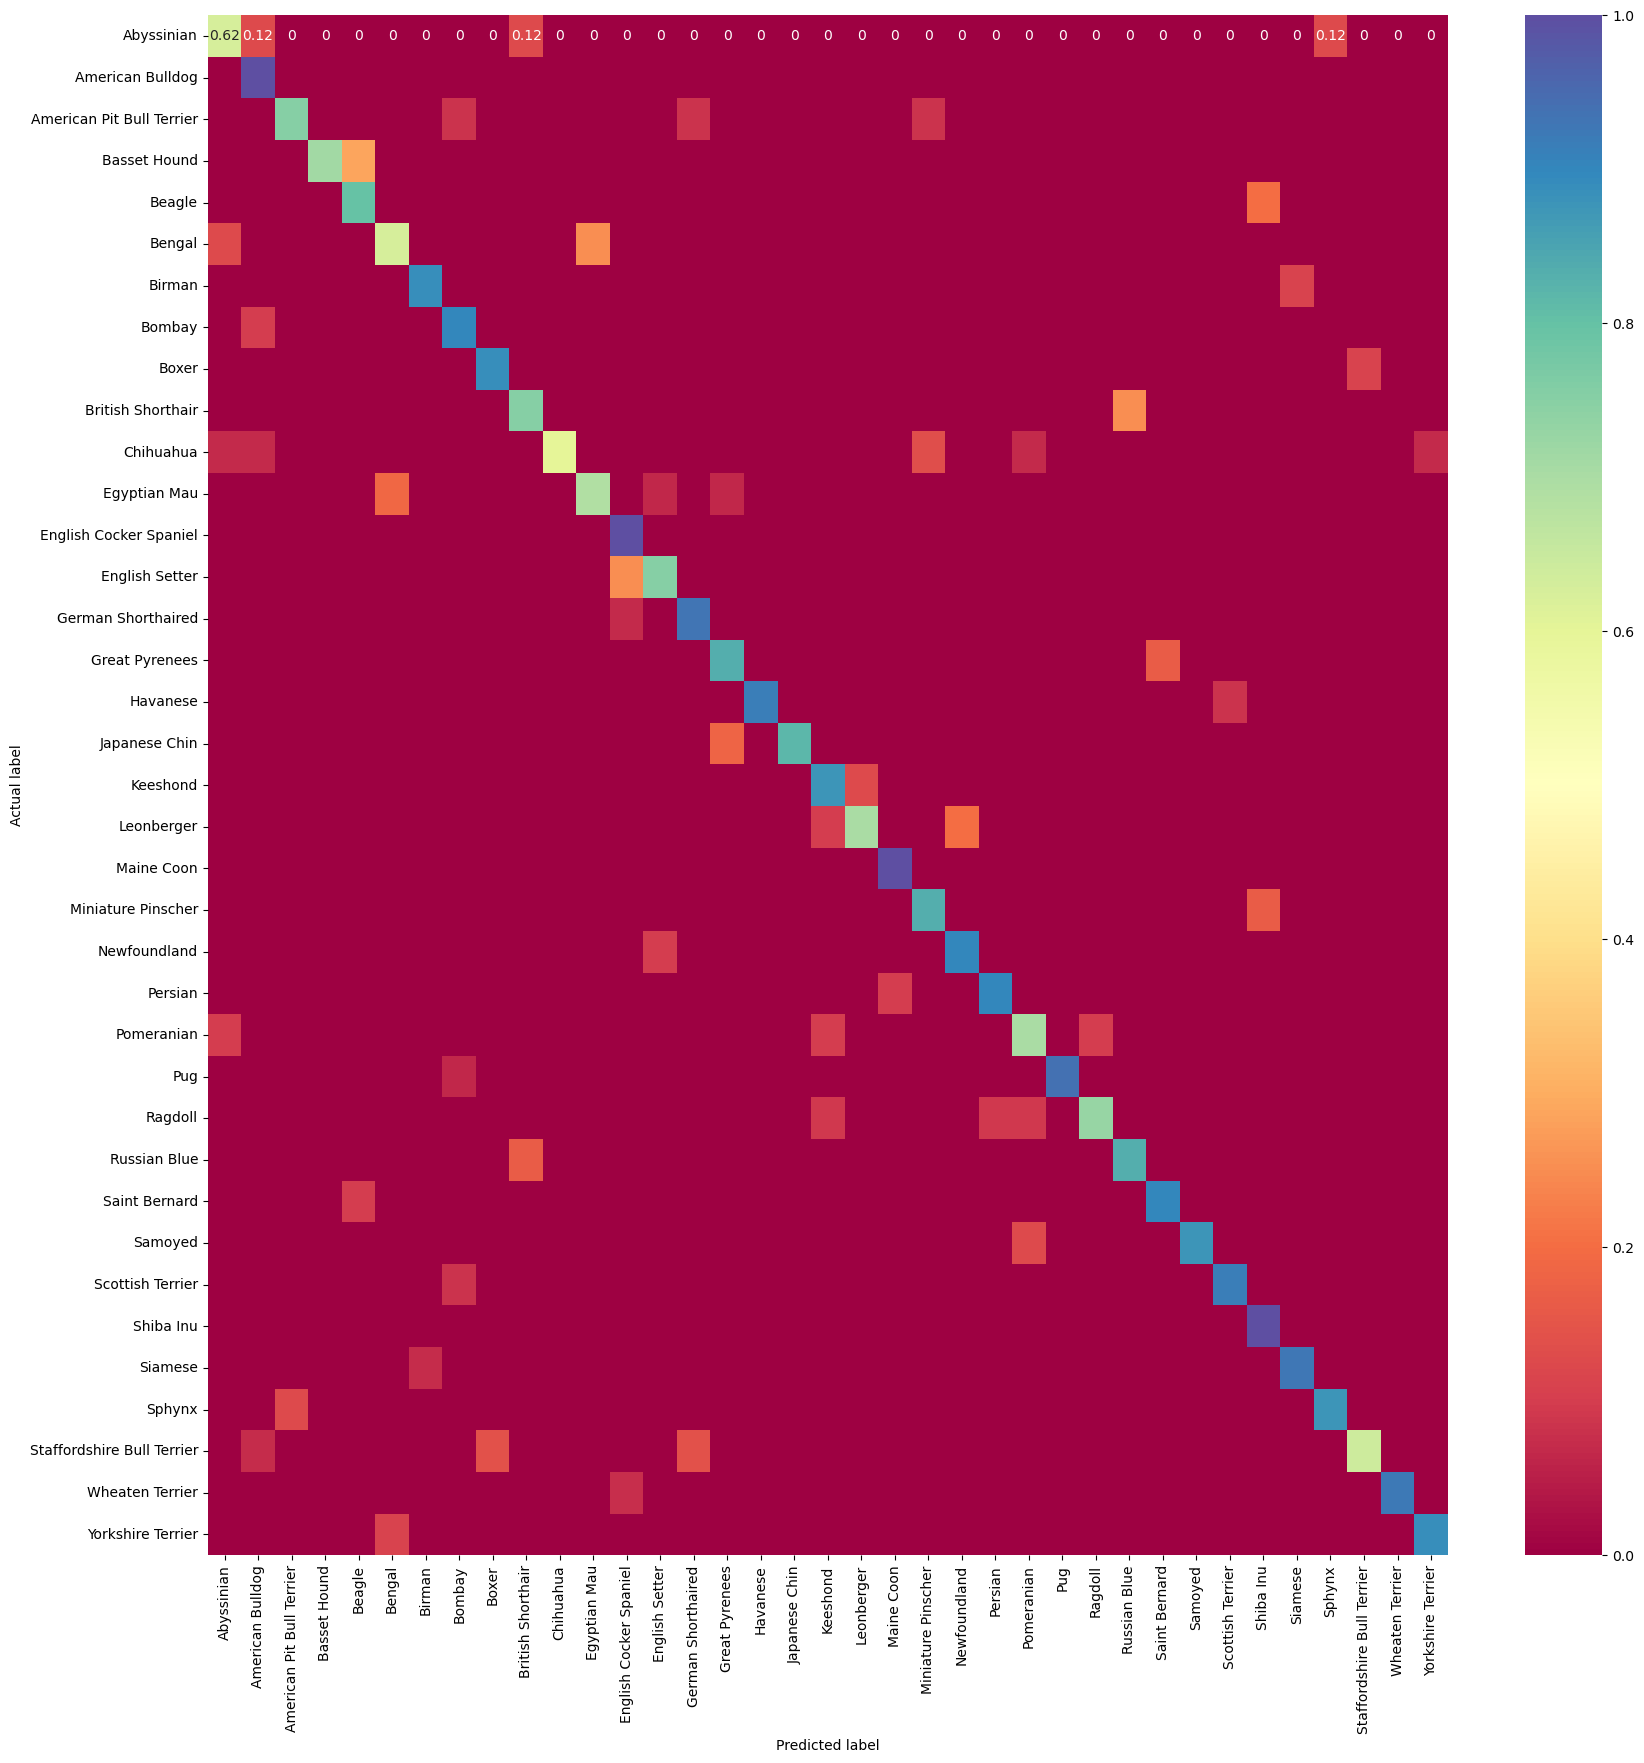

In [23]:
import seaborn as sns
cmat = confmat.compute().cpu().numpy()

fig, ax = plt.subplots(figsize=(20,20))

df_cm = pd.DataFrame(cmat, index = range(len(classes)), columns=range(len(classes)))
ax = sns.heatmap(df_cm, annot=True, fmt='.2g', cmap='Spectral')
ax.set_yticklabels([classes[i] for i in range(len(classes))], rotation=0)
ax.set_xticklabels([classes[i] for i in range(len(classes))], rotation=90)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
plt.show(block=False)